<a href="https://colab.research.google.com/github/Batman511/Numerical_methods_7sem/blob/main/3)%20%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%20%D0%BC%D0%B8%D0%BD%D0%B8%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D1%85%20%D0%BD%D0%B5%D0%B2%D1%8F%D0%B7%D0%BE%D0%BA%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D1%83%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%9F%D1%83%D0%B0%D1%81%D1%81%D0%BE%D0%BD%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix

# Постановка задачи

In [ ]:
# Ограничения
x_min = 0
x_max = 1
y_min = 0
y_max = 2

# Шаг сетки
hx = 0.1
hy = 0.1

# сетка
xk = np.arange(x_min+hx, x_max, hx)
yk = np.arange(y_min+hy, y_max, hy)

In [ ]:
# аналитическое решение  u
def solution(x, y):
    return (3*x*x+y*y)*np.sin(2*x+y) + 3*x*x + 2*y

# правая часть уравнения Лапласа  u_xx + u_yy = f(x, y)
def f(x, y):
   return -5*(3*x*x+y*y)*np.sin(2*x+y) + 8*np.sin(2*x+y) + 24*x*np.cos(2*x+y) + 4*y*np.cos(2*x+y) + 6

# Граничные условия
def mu_x_1(y):
    """
    mu_x_1(y) = mu(0, y)
    """
    return y*(y*np.sin(y) + 2)

def mu_x_2(y):
    """
    mu_x_2(y) = mu(1, y)
    """
    return (y*y+3)*np.sin(y+2) + 2*y + 3

def mu_y_1(x):
    """
    mu_y_1(x) = mu(x, 0)
    """
    return 3*x*x*(np.sin(x) + np.cos(x))**2

def mu_y_2(x):
    """
    mu_y_2(x) = mu(x, 2)
    """
    return 3*x*x + (3*x*x + 4)*np.sin(2*x + 2) + 4

# Решение СЛАУ методом минимальных невязок (итерационный метод)

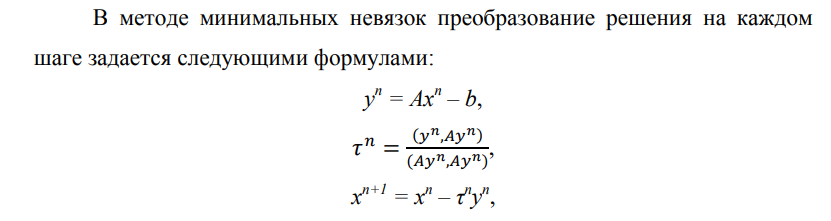

In [ ]:
def min_nevyazka(A, b, eps = 1e-8):
    n = len(A.toarray())
    x = np.zeros(n)
    Ax = A.dot(x)

    norm0 = np.linalg.norm(Ax - b)
    norm = norm0
    iter = 0

    while norm > eps*norm0:
        iter += 1
        y = Ax - b
        Ay = A.dot(y)

        tau = Ay.dot(y) / Ay.dot(Ay)
        x = x - tau * y
        Ax = A.dot(x)
        norm = np.linalg.norm(Ax - b)
    return x, iter

In [ ]:
def builder_matrix_sol(task, net, eps = 1e-8):
    f = task[0]
    mu_x1 = task[1]
    mu_x2 = task[2]
    mu_y1 = task[3]
    mu_y2 = task[4]

    hx, hy = net[0], net[1]
    x_min, x_max, y_min, y_max = net[2], net[3], net[4], net[5]

    x = np.arange(x_min+hx, x_max, hx)
    y = np.arange(y_min+hy, y_max, hy)
    N = len(x)
    M = len(y)

    u = np.zeros((N, M))
    A = np.zeros(( N*M, N*M))
    b = np.zeros(N*M)

    for j in range(M):
        for i in range(N):
            A[j*N + i, j*N + i] = 2*(hx**2 + hy**2)
            b[j*N + i] = -f(x[i], y[j]) * hx**2 * hy**2   
            if j == 0:
                A[j*N + i][(j+1)*N + i] = -hx**2 
                b[j*N + i] += mu_y1(x[i]) * hx**2        
            elif j == M - 1:
                A[j*N + i][(j-1)*N + i] = -hx**2
                b[j*N + i] += mu_y2(x[i]) * hx**2       
            else:
                A[j*N + i][(j-1)*N + i] = -hx**2
                A[j*N + i][(j+1)*N + i] = -hx**2

            if i == 0:
                A[j*N + i][j*N + i + 1] = -hy**2
                b[j*N + i] += mu_x1(y[j]) * hy**2       
            elif i == N - 1:
                A[j*N + i][j*N + i - 1] = -hy**2
                b[j*N + i] += mu_x2(y[j]) * hy**2       
            else:
                A[j*N + i][j*N + i - 1] = -hy**2
                A[j*N + i][j*N + i + 1] = -hy**2

    A = csr_matrix(A)   # Сжатая матрица разреженных строк
    u = min_nevyazka(A, b, eps)[0]      
    return u 

# Графики + макс. ошибка

In [ ]:
%time
# f, граница, сетка
task = (f, mu_x_1, mu_x_2, mu_y_1, mu_y_2)
net = (hx, hy, x_min, x_max, y_min, y_max)

# численное решение
u0 = builder_matrix_sol(task, net)
u = u0.reshape((len(yk), len(xk)))

# аналитическое решение
analytical_solution0 = np.array([solution(i, j) for j in yk for i in xk])
analytical_solution = analytical_solution0.reshape((len(yk), len(xk)))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.34 µs


График распределения температуры

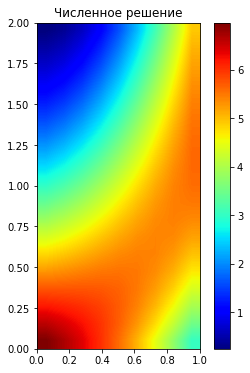

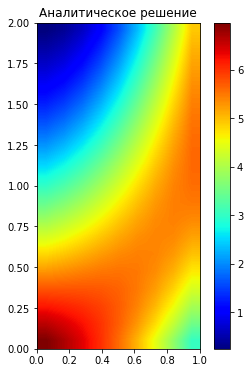

In [ ]:
plt.figure(figsize=(5,6))
plt.imshow(u, extent=[x_min, x_max, y_min, y_max], interpolation = 'bilinear', cmap = 'jet')
plt.colorbar()
plt.title("Численное решение")
plt.show()

plt.figure(figsize=(5,6))
plt.title("Аналитическое решение")
# plt.imshow(analytical_solution, extent=[x_min, x_max, y_min, y_max], cmap='rainbow', interpolation='bilinear')   # более плавный ,  cmap='magma'
plt.imshow(analytical_solution, extent=[x_min, x_max, y_min, y_max], interpolation = 'bilinear', cmap = 'jet')
plt.colorbar()
plt.show()

In [ ]:
print("Макс ошибка:           ",max(abs(u0 - analytical_solution0)))

Макс ошибка:            0.00833083885192698


Карта распределения модуля разности численного решения и аналитического

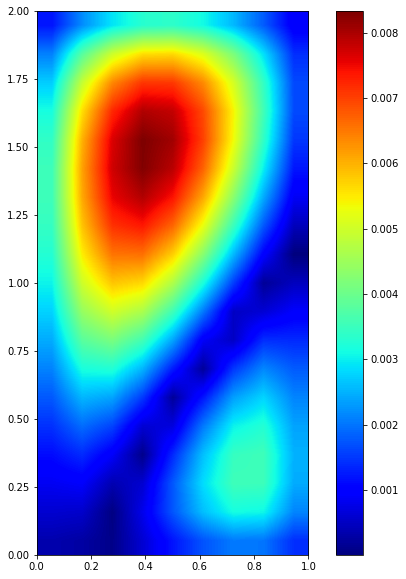

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(abs(u-analytical_solution), extent=[x_min, x_max, y_min, y_max], interpolation = 'bilinear', cmap = 'jet')
plt.colorbar()
plt.show()

## просто

In [ ]:
hrange =  [0.001, 0.002 ,0.005, 0.025, 0.05, 0.1,  0.125 ]

error_1 = np.zeros(len(hrange))
error_2 = np.zeros(len(hrange))

for j in range(len(hrange)):
    hi = hrange[j]
    t = hi
    tn_h = np.arange(tmin, tmax+t, t)
    xk_h = np.arange(xmin, xmax+hi, hi)
    u1 = [phi(xk_h[i]) for i in range(len(xk_h))]
    y_1, y_2 = np.zeros(len(xk_h)),  [0 for i in range(len(xk_h))]
    u2 = [phi(xk_h[i]) for i in range(len(xk_h))]
     
    y_real = [solution(xk_h[k], tn_h[-1]) for k in range(len(xk_h))]
    for i in range(1, len(tn_h)):
        y_1, y_2  = next_line_1(u1, t, sigma, i,  hi), next_line_2(u2, t, sigma, i,  hi)
        u1, u2  = y_1.copy(),  y_2.copy()
         
    error_1[j] = np.log(max([abs(y_1[j] - y_real[j]) for j in range(len(y_real))]))
    error_2[j] = np.log(max([abs(y_2[j] - y_real[j]) for j in range(len(y_real))]))

plt.figure()
plt.title("Зависимость логарифма макс. ошибки от шага")
plt.xlabel("log(h)")
plt.ylabel("log(max_error)")
plt.grid()
plt.plot(np.log(hrange), error_1, color='red',label="1 порядок")
plt.legend(loc='lower right')

plt.figure()
plt.title("Зависимость логарифма макс. ошибки от шага")
plt.xlabel("log(h)")
plt.ylabel("log(max_error)")
plt.grid()
plt.plot(np.log(hrange), error_2, color='blue',label="2 порядок")
plt.legend(loc='lower right')